In [1]:
import os
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Folder containing your .json files
folder_path = "./output"  # adjust as needed

# Prepare dataframe columns
columns = ["task", "timestamp", "temperature", "attempt", "justification", "answer"]
data = []

# Iterate through all .json files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".json"):
        match = re.match(r"(\d{4}_\d{2}_\d{2}_\d{2}_\d{2}_\d{2})_(.+?)_(\d)(?:_(\d+))?\.json", filename)
        if not match:
            continue
            
        timestamp = match.group(1)
        task = match.group(2)
        temperature = match.group(3)
        attempt = match.group(4) if match.group(4) else "1"

        # Load JSON
        with open(os.path.join(folder_path, filename), "r", encoding="utf-8") as f:
            content = json.load(f)

        # Extract justification and answer (depending on schema)
        justification = content.get("loesungsweg", "").strip()

        # Determine which answer field exists
        if "antwortoption" in content:  # MC
            answer = content["antwortoption"].strip()
        elif "loesung" in content:  # numeric or formula
            # kann float oder string sein
            answer = str(content["loesung"]).strip()
        else:
            answer = "NA"

        # Append row
        data.append([task, timestamp, temperature, attempt, justification, answer])

# Create dataframe
df = pd.DataFrame(data, columns=columns)

# Replace missing or empty answers with 'NA' for clear counting
df['answer'] = df['answer'].replace('', 'NA').fillna('NA')

## Preprocess LAMPEN data

In [2]:
# TASK : Glühlampen ----

df_LAMPEN = df[df.task == "Glühlampen_MC"].copy()

def score_per_option_simple(
    answer_str: str,
    correct: str = "D",
    options=("A", "B", "C", "D"),
    normalize: bool = True,
) -> float:
    """
    Scoring:
      +1 if the correct option is selected,
      +1 for each incorrect option NOT selected.
    If the selection is empty or contains anything outside 'options', score = 0.

    Parameters
    ----------
    answer_str : str
        Comma-separated selections like "A", "A,C", "B,D".
    correct : str
        The single correct option label.
    options : tuple[str]
        Allowed option labels.
    normalize : bool
        If True, return score in [0,1]; else raw points.

    Returns
    -------
    float
    """
    opts = tuple(o.upper() for o in options)
    correct = correct.upper()
    if correct not in opts:
        raise ValueError(f"Correct option '{correct}' must be in options {opts}")

    # Parse comma-separated selections
    if pd.isna(answer_str):
        return 0.0
    tokens = [t.strip().upper() for t in str(answer_str).split(",")]
    selected = {t for t in tokens if t}  # drop empties

    # Invalid or empty selection -> 0 points
    if not selected or any(t not in opts for t in selected):
        return 0.0

    # Score
    points = 0
    if correct in selected:
        points += 1
    for o in opts:
        if o == correct:
            continue
        if o not in selected:
            points += 1

    return points / len(opts) if normalize else float(points)

def describe(series):
    return {
        "mean": series.mean(),
        "std":  series.std(ddof=1),   # sample SD
        "min":  series.min(),
        "max":  series.max(),
        "n":    series.count()
    }


# --- Example usage on a DataFrame ---
# df_LAMPEN['answer'] contains strings like "A", "A,C", "B,D", "NA", "foo", etc.
df_LAMPEN["correct"] = df_LAMPEN["answer"].apply(
    lambda s: score_per_option_simple(s, correct="D", options=("A","B","C","D"), normalize=True)
)


# 1) Ensure proper types
df_LAMPEN["timestamp"] = pd.to_datetime(df_LAMPEN["timestamp"], format="%Y_%m_%d_%H_%M_%S", errors="coerce")

# 2) Some Summary Statistics
raw_temp1 = df_LAMPEN[df_LAMPEN["temperature"] == "1"]["correct"].dropna()

stats_temp1 = describe(raw_temp1)

print(stats_temp1)


# 3) Build series for each temperature
# Temp = 1 -> average across attempts per timestamp
temp1_LAMPEN = (
    df_LAMPEN[df_LAMPEN["temperature"] == "1"]
    .groupby("timestamp", as_index=False)
    .agg(mean_correct=("correct", "mean"))
    .sort_values("timestamp")
)

stats_temp1_LAMPEN_aggr = describe(temp1_LAMPEN['mean_correct'])
print(stats_temp1_LAMPEN_aggr)



{'mean': 0.631998556998557, 'std': 0.2602888755639108, 'min': 0.0, 'max': 1.0, 'n': 6930}
{'mean': 0.631998556998557, 'std': 0.08292483014490977, 'min': 0.375, 'max': 0.875, 'n': 693}


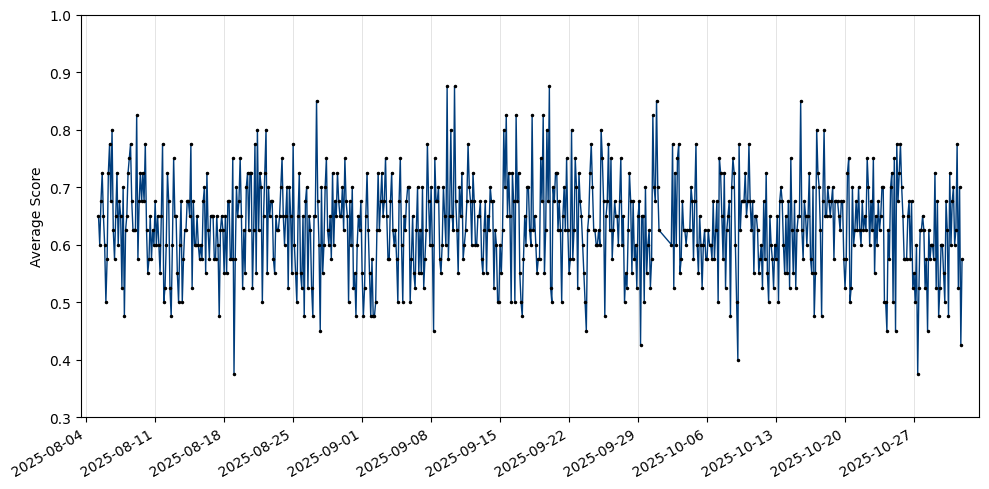

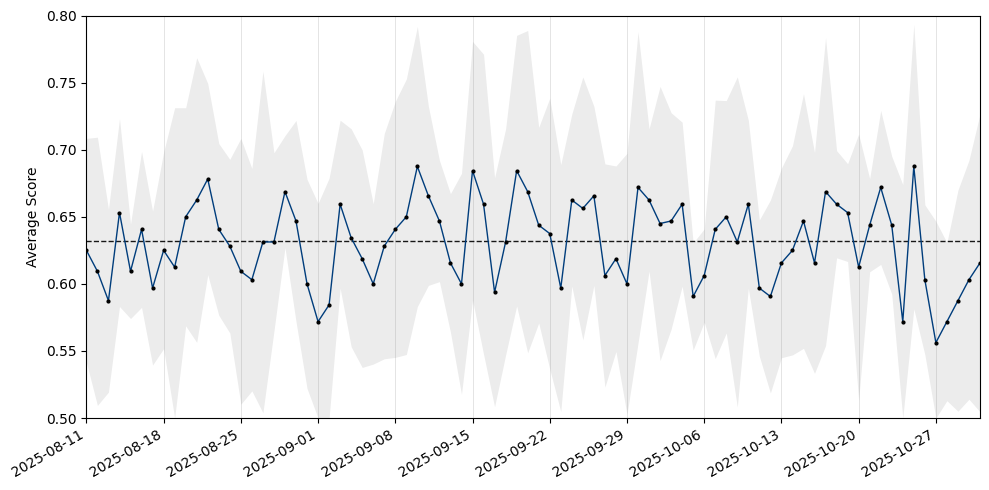

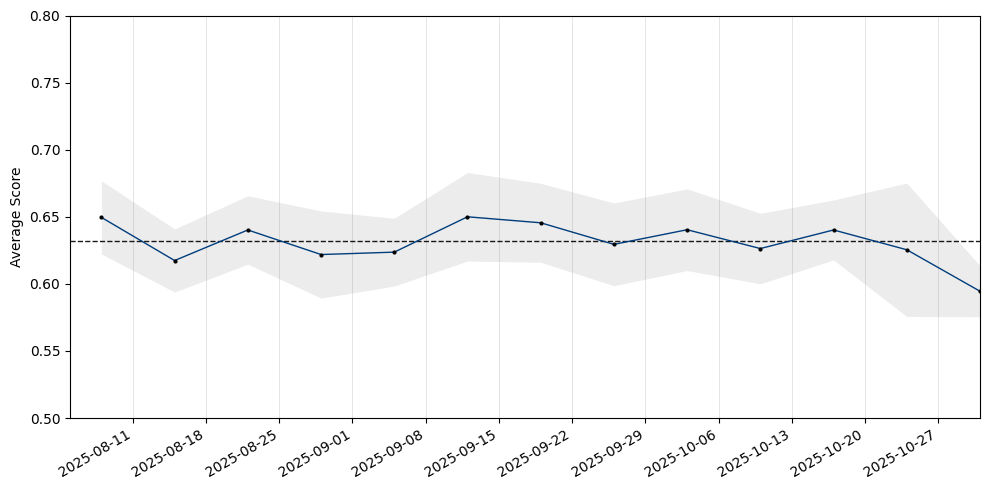

In [4]:
# 3) Plot overall
import matplotlib.dates as mdates
from datetime import timedelta
from scipy.stats import linregress

from pathlib import Path

# Ensure ./Figures exists (create parents if needed)
FIG_DIR = Path("./Figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)


plt.figure(figsize=(10, 5))
plt.plot(
    temp1_LAMPEN["timestamp"],
    temp1_LAMPEN["mean_correct"],
    marker='o',
    markersize=1.5,
    lw=1,
    color='#003D7C',
    markerfacecolor='black',
    markeredgecolor='black',
    label="Temperature = 1 (mean over attempts)"
)

plt.ylabel("Average Score")
plt.ylim(0.3, 1.0)
plt.margins(x=0.02)

# --- X-axis ticks: every Monday at 00:00 ---
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# --- Vertical grid lines for each tick ---
ax.grid(axis='x', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig(
    "./Figures/Visualization_all_data.pdf",
    format="pdf",
    bbox_inches="tight"
)
plt.show()



 # 4) plot aggregated over weekdays

# --- 1) Aggregate to daily mean and std (8 points -> 1 per day) ---
tmp = temp1_LAMPEN.copy()
tmp["timestamp"] = pd.to_datetime(tmp["timestamp"])
tmp["day"] = tmp["timestamp"].dt.floor("D")

daily = (
    tmp.groupby("day", as_index=False)
       .agg(mean_correct=("mean_correct", "mean"),
            sd_correct=("mean_correct", "std"),
            n=("mean_correct", "size"))
       .rename(columns={"day": "timestamp"})
       .sort_values("timestamp")
)

# If a day has only one sample, std is NaN; replace with 0 to avoid gaps in band
daily["sd_correct"] = daily["sd_correct"].fillna(0.0)

# Optional: clip band to valid y-range if desired
ymin = 0.50
ymax = 0.80
band_lower = np.clip(daily["mean_correct"] - daily["sd_correct"], ymin, ymax)
band_upper = np.clip(daily["mean_correct"] + daily["sd_correct"], ymin, ymax)

# --- 2) Fit linear regression trend line ---
# Convert timestamps to numeric days (so we can regress)
x = (daily["timestamp"] - daily["timestamp"].min()).dt.total_seconds() / (24 * 3600)
y = daily["mean_correct"]

slope, intercept, r_value, p_value, std_err = linregress(x, y)
r2 = r_value**2

# Compute fitted line values
y_fit = intercept + slope * x

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 5))

# Grey SD band first so the line draws on top
ax.fill_between(
    daily["timestamp"],
    band_lower,
    band_upper,
    color="gray",
    alpha=0.15,
    linewidth=0,
    label="_nolegend_"  # don't add to legend
)

ax.axhline(
    y=0.631999,
    color="black",
    linestyle="--",
    linewidth=1.0,
    alpha=0.9,
    label="Overall mean = 0.632"
)

ax.plot(
    daily["timestamp"],
    daily["mean_correct"],
    marker='o',
    markersize=2.0,
    lw=1,
    color="#003D7C",
    markerfacecolor='black',
    markeredgecolor='black',
    label="Temperature = 1 (daily mean ±1 SD)"
)


ax.set_ylabel("Average Score")
ax.set_ylim(ymin, ymax)
plt.margins(x=0.02)

# Weekly ticks every Monday 00:00
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Start ticks exactly at the first Monday 00:00 within data range
start = daily["timestamp"].min()
start_monday = (start + timedelta(days=(7 - start.weekday()) % 7)).replace(hour=0, minute=0, second=0, microsecond=0)
ax.set_xlim(start_monday, daily["timestamp"].max())

# Vertical grid at each tick
ax.grid(axis='x', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

plt.gcf().autofmt_xdate()
plt.tight_layout()
fig.savefig("./Figures/Visualization_aggregated_days.pdf", format="pdf", bbox_inches="tight")
plt.show()


 # 5) plot aggregated over weeks

import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from datetime import timedelta

# --- Weekly aggregation: Mon..Sun, point at Thursday ---
weekly = (
    daily.assign(
        week_start = daily["timestamp"].dt.to_period("W-MON").dt.start_time  # Monday 00:00
    )
    .groupby("week_start", as_index=False)
    .agg(
        mean_correct=("mean_correct", "mean"),
        sd_correct=("mean_correct", "std"),
        n=("mean_correct", "size")
    )
    .sort_values("week_start")
)

# Standard deviation might be NaN if only one day in that week
weekly["sd_correct"] = weekly["sd_correct"].fillna(0.0)

# Plot x-position at Thursday (Monday + 3 days)
weekly["week_mid"] = weekly["week_start"] + pd.Timedelta(days=3)  # Thursday 00:00

# Build SD band (use your existing ymin/ymax from previous cell)
band_lower_w = np.clip(weekly["mean_correct"] - weekly["sd_correct"], ymin, ymax)
band_upper_w = np.clip(weekly["mean_correct"] + weekly["sd_correct"], ymin, ymax)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 5))

# Grey SD band first
ax.fill_between(
    weekly["week_mid"],
    band_lower_w,
    band_upper_w,
    color="gray",
    alpha=0.15,
    linewidth=0,
    label="_nolegend_"
)

ax.axhline(
    y=0.631999,
    color="black",
    linestyle="--",
    linewidth=1.0,
    alpha=0.9,
    label="Overall mean = 0.632"
)

# Weekly mean at Thursday
ax.plot(
    weekly["week_mid"],
    weekly["mean_correct"],
    marker='o',
    markersize=2.0,
    lw=1,
    color="#003D7C",
    markerfacecolor='black',
    markeredgecolor='black',
    label="Temperature = 1 (weekly mean ±1 SD)"
)

ax.set_ylabel("Average Score")
ax.set_ylim(ymin, ymax)
plt.margins(x=0.02)

# X-axis grid/ticks every Monday 00:00 (vertical lines on Mondays; points plotted on Thursdays)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Align limits to Monday grid on the left, last Thursday on the right
start_monday = weekly["week_start"].min()
ax.set_xlim(start_monday, weekly["week_mid"].max())

# Vertical grid at each tick
ax.grid(axis='x', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

plt.gcf().autofmt_xdate()
plt.tight_layout()
fig.savefig("./Figures/Visualization_aggregated_weeks.pdf", format="pdf", bbox_inches="tight")
plt.show()



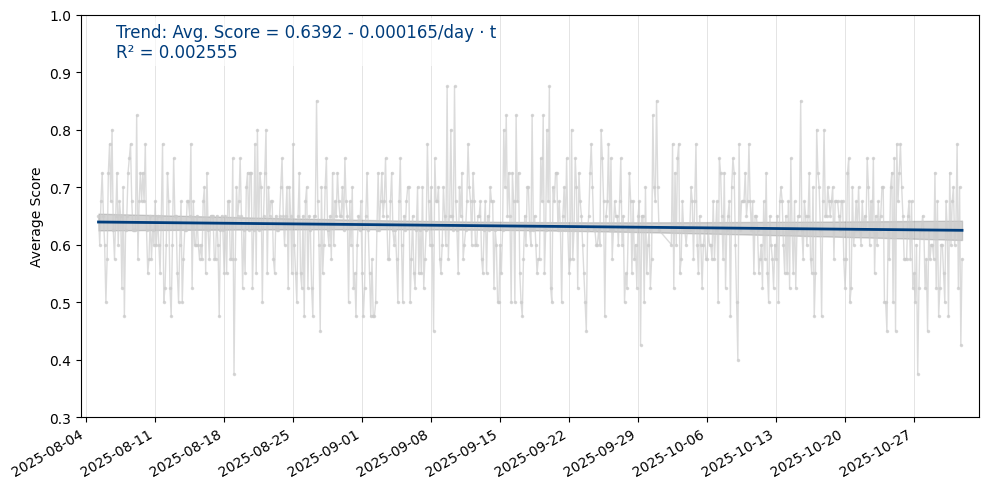


=== OLS trend with HAC (Newey–West) ===
N = 693, maxlags = 56

R2 = 0.0025547114635183776
                   coef    HAC_se          t   p_value    CI_low   CI_high
Intercept      0.639180  0.007421  86.134122  0.000000  0.624636  0.653725
Slope_per_day -0.000165  0.000163  -1.008021  0.313445 -0.000485  0.000155

Drift interpretation:
Slope (per day) = -0.000164592
HAC t-value (slope) = -1.00802
HAC p-value (slope) = 0.313445


In [5]:
# OLS with HAC errors (Newey-West)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm

# --- Data prep ---
df1 = temp1_LAMPEN[["timestamp", "mean_correct"]].dropna().copy()
df1["timestamp"] = pd.to_datetime(df1["timestamp"])
df1 = df1.sort_values("timestamp")

t0 = df1["timestamp"].min()
x_days = (df1["timestamp"] - t0).dt.total_seconds() / (24 * 3600)  # days since start
y = df1["mean_correct"].to_numpy()

# Design matrix: [1, t]
X = sm.add_constant(x_days.to_numpy())
T = len(df1)

# --- OLS with HAC / Newey–West ---
period_days = 7
sampling_hours = 3
maxlags = int(period_days * 24 / sampling_hours)  
#maxlags = int(T ** (1/4))
maxlags = max(1, min(maxlags, T - 1))

res = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})

# Fitted mean trend
y_fit = res.predict(X)

# --- 95% confidence band for the MEAN trend ---
V = res.cov_params()
Xmat = np.asarray(X)
var_mean = np.einsum("ij,jk,ik->i", Xmat, V, Xmat)
se_mean = np.sqrt(var_mean)

z = 1.96
lower = y_fit - z * se_mean
upper = y_fit + z * se_mean

# --- Plot ---
plt.figure(figsize=(10, 5))

# Signal in light grey (line + points same color)
plt.plot(
    df1["timestamp"],
    df1["mean_correct"],
    marker="o",
    markersize=1.5,
    lw=1,
    color="0.80",            # lighter grey
    alpha=0.7,
    markerfacecolor="0.80",
    markeredgecolor="0.80",
    label="Signal"
)

# Trendline
plt.plot(
    df1["timestamp"],
    y_fit,
    color="#003D7C",
    lw=2.0,
    label=f"OLS trend (HAC, maxlags={maxlags})"
)

# Confidence band (darker grey than signal)
plt.fill_between(
    df1["timestamp"].to_numpy(),
    lower,
    upper,
    color="0.45",           # darker grey
    alpha=0.3,
    label="95% CI (mean trend)"
)

plt.ylabel("Average Score")
plt.ylim(0.3, 1.0)
plt.margins(x=0.02)

# X-axis formatting
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.grid(axis="x", color="gray", linestyle="-", linewidth=0.5, alpha=0.3)

plt.gcf().autofmt_xdate()
#plt.legend(loc="best")

# --- Add label text inside the plot (top-left corner) ---
ax = plt.gca()
ymin, ymax = ax.get_ylim()

text_x = (
    df1["timestamp"].min()
    + (df1["timestamp"].max() - df1["timestamp"].min()) * 0.02
)
text_y = ymax - 0.02 * (ymax - ymin)

intercept = res.params[0]
slope = res.params[1]

# Classical R^2 from the OLS fit (as in the original example)
r2 = res.rsquared

ax.text(
    text_x,
    text_y,
    (
        f"Trend: Avg. Score = {intercept:.4f} "
        f"{'+' if slope >= 0 else '-'} {abs(slope):.6f}/day · t\n"
        f"R² = {r2:.6f}"
    ),
    color="#003D7C",
    fontsize=12,
    va="top",
    ha="left",
    bbox=dict(
        facecolor="white",
        alpha=0.6,
        edgecolor="none",
        pad=3
    )
)


plt.tight_layout()
plt.savefig("./Figures/Visualization_all_data_trend_line.pdf", format="pdf", bbox_inches="tight")
plt.show()

# --- Output regression results ---
out = pd.DataFrame(
    {
        "coef": res.params,
        "HAC_se": res.bse,
        "t": res.tvalues,
        "p_value": res.pvalues,
        "CI_low": res.conf_int()[:, 0],
        "CI_high": res.conf_int()[:, 1],
    },
    index=["Intercept", "Slope_per_day"],
)

print("\n=== OLS trend with HAC (Newey–West) ===")
print(f"N = {T}, maxlags = {maxlags}\n")
print(f"R2 = {res.rsquared}")
print(out)

print("\nDrift interpretation:")
print(f"Slope (per day) = {res.params[1]:.6g}")
print(f"HAC t-value (slope) = {res.tvalues[1]:.6g}")
print(f"HAC p-value (slope) = {res.pvalues[1]:.6g}")



## Heatmap

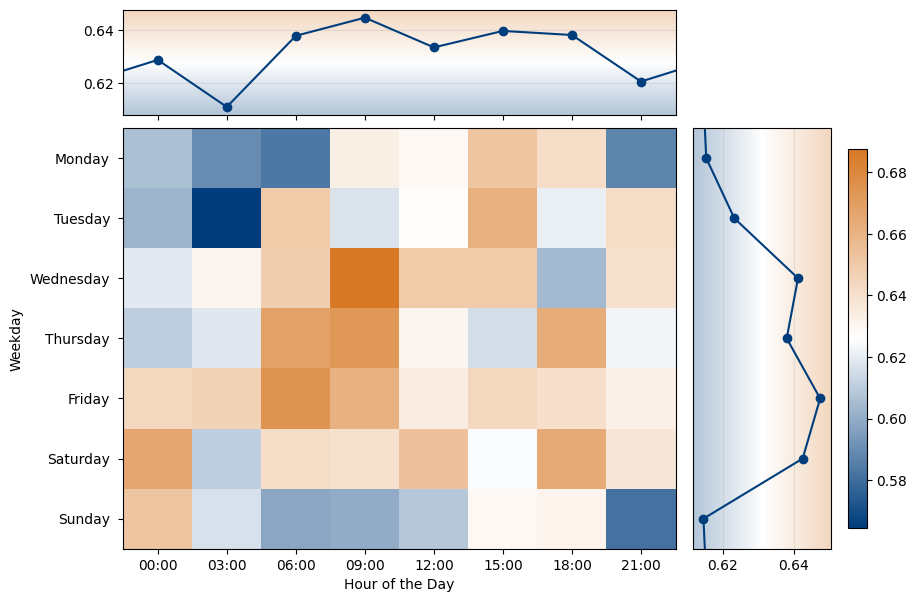

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list(
    "blue_white_orange",
    ["#003D7C", "#FFFFFF", "#D67824"]
)

def _connect_periodic_top(ax, x_centers, y_vals, x_left=0.0, x_right=24.0, **plot_kwargs):
    """
    Draw a visible periodic connection between last and first point within [x_left, x_right]
    by splitting at the boundary: last -> x_right and x_left -> first.
    """
    x_last, y_last = float(x_centers[-1]), float(y_vals[-1])
    x_first, y_first = float(x_centers[0]), float(y_vals[0])

    # Interpret periodic wrap as connecting (x_last, y_last) to (x_first + period, y_first)
    period = x_right - x_left
    x_first_ext = x_first + period

    # y at x_right along line from (x_last, y_last) to (x_first_ext, y_first)
    t_right = (x_right - x_last) / (x_first_ext - x_last)
    y_right = y_last + t_right * (y_first - y_last)

    # y at x_left along line from (x_last - period, y_last) to (x_first, y_first)
    x_last_ext = x_last - period
    t_left = (x_left - x_last_ext) / (x_first - x_last_ext)
    y_left = y_last + t_left * (y_first - y_last)

    # draw two segments inside the visible range
    ax.plot([x_last, x_right], [y_last, y_right], **plot_kwargs)
    ax.plot([x_left, x_first], [y_left, y_first], **plot_kwargs)

def _connect_periodic_right(ax, x_vals, y_centers, y_top=0.0, y_bottom=7.0, **plot_kwargs):
    """
    Draw a visible periodic connection between last and first weekday within [y_top, y_bottom]
    by splitting at the boundary: last -> y_bottom and y_top -> first.
    Here x is the value axis (mean), y is weekday position.
    """
    x_last, y_last = float(x_vals[-1]), float(y_centers[-1])
    x_first, y_first = float(x_vals[0]), float(y_centers[0])

    period = y_bottom - y_top
    y_first_ext = y_first + period

    # x at y_bottom along line from (x_last, y_last) to (x_first, y_first_ext)
    t_bot = (y_bottom - y_last) / (y_first_ext - y_last)
    x_bot = x_last + t_bot * (x_first - x_last)

    # x at y_top along line from (x_last, y_last - period) to (x_first, y_first)
    y_last_ext = y_last - period
    t_top = (y_top - y_last_ext) / (y_first - y_last_ext)
    x_top = x_last + t_top * (x_first - x_last)

    ax.plot([x_last, x_bot], [y_last, y_bottom], **plot_kwargs)
    ax.plot([x_top, x_first], [y_top, y_first], **plot_kwargs)

def plot_heatmap_with_marginals(df, title=None, outpath="./Figures/Visualization_Heatmap.pdf"):
    df = df.copy()
    df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])

    weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday",
                     "Friday", "Saturday", "Sunday"]
    hour_bins = np.array([0, 3, 6, 9, 12, 15, 18, 21])

    # weekday + 3h measurement times
    df["weekday"] = df.iloc[:, 0].dt.day_name(locale="en_US")
    df["hour"] = (df.iloc[:, 0].dt.hour // 3) * 3
    df = df[df["weekday"].isin(weekday_order) & df["hour"].isin(hour_bins)]

    pivot = (
        df.groupby(["weekday", "hour"])["mean_correct"]
          .mean()
          .reset_index()
          .pivot(index="weekday", columns="hour", values="mean_correct")
          .reindex(index=weekday_order, columns=hour_bins)
    )

    Z = pivot.values.astype(float)
    Zm = np.ma.masked_invalid(Z)

    # marginals
    col_marg = np.nanmean(Z, axis=0)  # per hour
    row_marg = np.nanmean(Z, axis=1)  # per weekday

    # heatmap scale
    vmin, vmax = Zm.min(), Zm.max()

    # edges/centers
    x_edges = np.r_[hour_bins, hour_bins[-1] + 3]          # 0..24
    x_centers = hour_bins + 1.5                            # 1.5..22.5
    y_edges = np.arange(len(weekday_order) + 1)            # 0..7
    y_centers = np.arange(len(weekday_order)) + 0.5        # 0.5..6.5

    marg_color = "#003D7C"

    # marginal ranges + ticks (separate)
    top_min = np.nanmin(col_marg) - 0.003
    top_max = np.nanmax(col_marg) + 0.003
    right_min = np.nanmin(row_marg) - 0.003
    right_max = np.nanmax(row_marg) + 0.003
    marg_ticks = [0.62, 0.64]

    # --- layout ---
    fig = plt.figure(figsize=(11, 7))
    gs = fig.add_gridspec(
        nrows=2, ncols=2,
        height_ratios=[1.5, 6],
        width_ratios=[6, 1.5],
        hspace=0.05, wspace=0.05
    )

    ax_hm  = fig.add_subplot(gs[1, 0])
    ax_top = fig.add_subplot(gs[0, 0], sharex=ax_hm)
    ax_r   = fig.add_subplot(gs[1, 1], sharey=ax_hm)

    # --- main heatmap ---
    hm = ax_hm.pcolormesh(
        x_edges, y_edges, Zm,
        shading="flat",
        cmap=cmap,
        vmin=vmin, vmax=vmax
    )
    ax_hm.set_ylim(len(weekday_order), 0)

    ax_hm.set_xticks(x_centers)
    ax_hm.set_xticklabels([f"{h:02d}:00" for h in hour_bins])
    ax_hm.set_xlabel("Hour of the Day")

    ax_hm.set_yticks(y_centers)
    ax_hm.set_yticklabels(weekday_order)
    ax_hm.set_ylabel("Weekday")
    ax_hm.tick_params(axis="y", left=True, labelleft=True, pad=6)

    # --- right marginal background: HORIZONTAL gradient ---
    Nx = 256
    ramp_x = np.linspace(vmin, vmax, Nx).reshape(1, Nx)
    ax_r.imshow(
        ramp_x,
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        aspect="auto",
        origin="lower",
        extent=[right_min, right_max, len(weekday_order), 0],
        alpha=0.30,
        zorder=0
    )

    # right marginal line
    ax_r.plot(row_marg, y_centers, marker="o",
              color=marg_color, markerfacecolor=marg_color, zorder=2)
    # visible periodic connection (Sun -> Mon) within the axes
    _connect_periodic_right(
        ax_r, row_marg, y_centers,
        y_top=0.0, y_bottom=float(len(weekday_order)),
        color=marg_color, linewidth=1.5, zorder=2
    )

    ax_r.tick_params(axis="y", left=False, labelleft=False)
    ax_r.set_xlabel("")
    ax_r.set_xlim(right_min, right_max)
    ax_r.set_xticks(marg_ticks)
    ax_r.grid(True, axis="x", alpha=0.3, zorder=1)
    ax_r.set_ylim(len(weekday_order), 0)

    # colorbar
    cbar = fig.colorbar(hm, ax=[ax_hm, ax_r], shrink=0.9, pad=0.02)
    cbar.set_label("")

    # --- CRITICAL FIX: match top width to heatmap ---
    fig.canvas.draw()
    pos = ax_hm.get_position()
    ax_top.set_position([pos.x0, ax_top.get_position().y0, pos.width, ax_top.get_position().height])

    # --- top marginal background: VERTICAL gradient ---
    Ny = 256
    ramp_y = np.linspace(vmin, vmax, Ny).reshape(Ny, 1)
    ax_top.imshow(
        ramp_y,
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        aspect="auto",
        origin="lower",
        extent=[x_edges[0], x_edges[-1], top_min, top_max],
        alpha=0.30,
        zorder=0
    )

    # top marginal line
    ax_top.plot(x_centers, col_marg, marker="o",
                color=marg_color, markerfacecolor=marg_color, zorder=2)
    # visible periodic connection (last -> first) within the axes
    _connect_periodic_top(
        ax_top, x_centers, col_marg,
        x_left=float(x_edges[0]), x_right=float(x_edges[-1]),
        color=marg_color, linewidth=1.5, zorder=2
    )

    ax_top.set_xlim(x_edges[0], x_edges[-1])
    ax_top.set_xticks(x_centers)
    ax_top.tick_params(axis="x", labelbottom=False)
    ax_top.set_ylabel("")
    ax_top.set_ylim(top_min, top_max)
    ax_top.set_yticks(marg_ticks)
    ax_top.grid(True, axis="y", alpha=0.3, zorder=1)

    if title:
        fig.suptitle(title, y=0.98)

    fig.savefig(outpath, format="pdf", bbox_inches="tight")
    plt.show()


plot_heatmap_with_marginals(temp1_LAMPEN)


## Missing Data imputation

In [7]:
# Apply the same constant-imputation to three DataFrames:
imputation_method = 'constant'

base_rows = [
        {'timestamp': '2025-10-01 06:00:00', 'weekday': 'Wednesday', 'hour': 6},
        {'timestamp': '2025-10-01 09:00:00', 'weekday': 'Wednesday', 'hour': 9},
        {'timestamp': '2025-10-01 12:00:00', 'weekday': 'Wednesday', 'hour': 12},
        {'timestamp': '2025-10-01 15:00:00', 'weekday': 'Wednesday', 'hour': 15},
        {'timestamp': '2025-10-01 18:00:00', 'weekday': 'Wednesday', 'hour': 18},
        {'timestamp': '2025-10-01 21:00:00', 'weekday': 'Wednesday', 'hour': 21},
        {'timestamp': '2025-10-02 00:00:00', 'weekday': 'Thursday', 'hour': 0},
        {'timestamp': '2025-10-02 03:00:00', 'weekday': 'Thursday', 'hour': 3},
        {'timestamp': '2025-10-02 06:00:00', 'weekday': 'Thursday', 'hour': 6}
    ]

def impute_constant(df, new_rows):
    df_missing = pd.DataFrame(new_rows)
    df_missing['timestamp'] = pd.to_datetime(df_missing['timestamp'], errors='coerce')

    # Compute dataset-specific mean
    mean_val = df['mean_correct'].mean()

    # Assign and combine
    df_missing = df_missing.assign(mean_correct=mean_val)
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df = pd.concat([df, df_missing], ignore_index=True)
    df = df.sort_values('timestamp').reset_index(drop=True)
    return df

if imputation_method == 'constant':
    temp1_LAMPEN = impute_constant(temp1_LAMPEN, base_rows)


## Fourier Analysis using Welchs Method

[Info] Original rows: 702
[Info] Rows after start and before cutoff : 702
[Info] Running bootstrap with n_boot=1000, shuffle_mode='permute', alpha=0.05
[Info] Figure saved to ./Figures/welch_amplitude_LAMPEN.svg


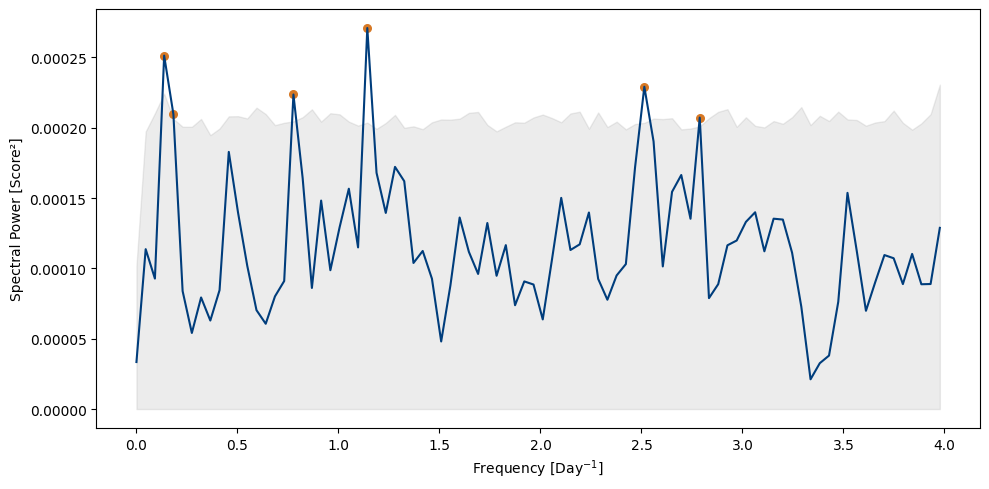

[Peaks] Significant peaks (frequency in cycles/day, period in days):
 frequency  period_days         psd  amplitude  upper_band  region_start_freq  region_end_freq
  0.137143      7.29167 0.000251226  0.0158501 0.000224211           0.137143         0.182857
  0.777143      1.28676 0.000223587  0.0149528 0.000204468           0.777143         0.777143
   1.14286        0.875 0.000270802  0.0164561 0.000203576            1.14286          1.14286
   2.51429     0.397727 0.000229091  0.0151358 0.000203408            2.51429          2.51429
   2.78857     0.358607 0.000207164  0.0143932 0.000200887            2.78857          2.78857
[Peaks] Sum of psd:
0.001181870367771547


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, get_window, detrend as sp_detrend, find_peaks


def welch_psd(
    DF,
    W=5,                              # target number of segments
    time_col="timestamp",
    val_col="mean_correct",
    use_detrend=False,                # linear detrend before Welch (else mean-center)
    window_name="hann",               # e.g. "hann", "hamming", "boxcar"
    overlap=0.5,                      # 0..1 (typical: 0.5)
    scaling="spectrum",               # "density" (PSD) or "spectrum" (|FFT|^2 scaled)
    start=None,
    cutoff=None,
    show=True,
    # --- Bootstrap additions ---
    n_boot=0,                         # number of bootstrap shuffles (0 = disabled)
    alpha=0.05,                       # significance level for bands (upper = 1-alpha)
    two_sided=False,                  # if True, compute lower/upper (alpha/2, 1-alpha/2)
    rng_seed=None,                    # reproducible randomness
    shuffle_mode="permute",           # 'permute' (random shuffle). (Can extend later)
    mark_significant=True,            # mark points where PSD > upper band
    # --- Peak extraction controls ---
    print_peaks=True,                 # print detected significant peaks
    min_prominence=0.0,               # minimum prominence for local maxima
    neighbor_tol_bins=1,              # tolerates +/- k bins around the apex to exceed upper band
    show_legend=True,
    savepath=None
):
    """
    Welch PSD for evenly sampled series (no resampling).
    Frequencies are returned in cycles/day.

    Bootstrap idea:
        Build an empirical significance band by shuffling y and recomputing Welch n_boot times.
        - Upper band = percentile 100*(1-alpha)
        - (Optional) Lower band = percentile 100*(alpha) [or alpha/2 if two_sided=True]
        Significant peaks: Pxx > upper band (one-sided test).
    """

    # quick counts
    print(f"[Info] Original rows: {len(DF)}")

    df = DF.copy().sort_values(time_col)
    df[time_col] = pd.to_datetime(df[time_col])
    if cutoff is None:
        cutoff = df[time_col].max()
    if start is None:
        start = df[time_col].min()
    df = df.loc[(df[time_col] <= cutoff) & (start <= df[time_col])]
    print(f"[Info] Rows after start and before cutoff : {len(df)}")


    y = df[val_col].to_numpy(dtype=float)
    t = df[time_col].to_numpy()

    # sampling rate from even timestamps (your code uses fixed 3h steps)
    dt_hours = 3  # (t[1] - t[0]).astype("timedelta64[s]").astype(float) / 3600.0
    fs_per_hour = 1.0 / dt_hours  # samples per hour

    # prep signal
    y_use = sp_detrend(y, type="linear") if use_detrend else (y - np.nanmean(y))

    # choose segment length from W; overlap
    N = len(y_use)
    if W <= 1 or N < 2*W:
        raise ValueError(f"W={W} too large for series length N={N}. Choose smaller W or provide longer series.")
    nperseg = N // W         # ~W segments
    noverlap = int(nperseg * overlap)
    if nperseg <= 1 or noverlap >= nperseg:
        raise ValueError(f"Invalid segment settings: nperseg={nperseg}, noverlap={noverlap}.")
    win = get_window(window_name, nperseg, fftbins=True)

    # Welch (f in cycles/hour -> convert to cycles/day)
    f_ch, Pxx = welch(
        y_use,
        fs=fs_per_hour,
        window=win,
        nperseg=nperseg,
        noverlap=noverlap,
        detrend=False,                 # already detrended/centered above
        return_onesided=True,
        scaling=scaling,               # "density" or "spectrum"
        average="mean",
    )
    f_cd = f_ch * 24.0
    freq_res_cpd = float(np.mean(np.diff(f_cd)))  # same as f_cd[1]-f_cd[0] for uniform grids
    
    # ----- Bootstrap band -----
    lower_band = None
    upper_band = None
    signif_mask = None

    if n_boot and n_boot > 0:
        print(f"[Info] Running bootstrap with n_boot={n_boot}, shuffle_mode='{shuffle_mode}', alpha={alpha}")
        rng = np.random.default_rng(rng_seed)
        P_boot = np.empty((n_boot, len(f_ch)), dtype=float)

        # helper to generate a shuffled surrogate
        def make_surrogate(vec):
            if shuffle_mode == "permute":
                return rng.permutation(vec)
            else:
                raise ValueError(f"Unsupported shuffle_mode: {shuffle_mode}")

        for i in range(n_boot):
            y_sur = make_surrogate(y_use)
            # compute Welch on surrogate
            _, P_s = welch(
                y_sur,
                fs=fs_per_hour,
                window=win,
                nperseg=nperseg,
                noverlap=noverlap,
                detrend=False,
                return_onesided=True,
                scaling=scaling,
                average="mean",
            )
            P_boot[i, :] = P_s

        if two_sided:
            lo_q = 100.0 * (alpha / 2.0)
            hi_q = 100.0 * (1.0 - alpha / 2.0)
            lower_band = np.percentile(P_boot, lo_q, axis=0)
            upper_band = np.percentile(P_boot, hi_q, axis=0)
        else:
            # one-sided (upper only) is typical for "peak" significance
            lower_band = None
            upper_band = np.percentile(P_boot, 100.0 * (1.0 - alpha), axis=0)

        # mark significant where PSD exceeds the upper band
        if upper_band is not None:
            signif_mask = Pxx > upper_band
        else:
            signif_mask = None

    # ----- Robust significant-peak extraction (works even if the apex bin is just below the band) -----
    def _extract_significant_peaks_robust(f, psd, upper, min_prominence=0.0, neighbor_tol_bins=1):
        f = np.asarray(f)
        psd = np.asarray(psd)
        upper = np.asarray(upper)
        if not (len(f) == len(psd) == len(upper)):
            raise ValueError("Lengths of frequency, PSD, and upper band must match.")

        sig = psd > upper
        idx = np.where(sig)[0]
        if idx.size == 0:
            return pd.DataFrame(columns=[
                "frequency", "period_days", "psd", "upper_band",
                "region_start_freq", "region_end_freq"
            ])

        # contiguous True regions in 'sig'
        cuts = np.where(np.diff(idx) > 1)[0]
        starts = np.r_[idx[0], idx[cuts + 1]]
        ends   = np.r_[idx[cuts], idx[-1]]

        rows = []
        for s, e in zip(starts, ends):
            seg_psd = psd[s:e+1]
            local_peaks, props = find_peaks(seg_psd, prominence=min_prominence)

            # if no internal local peaks, at least keep the region argmax
            if local_peaks.size == 0:
                k = s + int(np.argmax(seg_psd))
                peak_indices = [k]
            else:
                peak_indices = (s + local_peaks).tolist()

            # neighbor-tolerance: keep k if any bin within [k - tol, k + tol] exceeds upper
            if neighbor_tol_bins and neighbor_tol_bins > 0:
                kept = []
                n = len(psd)
                for k in peak_indices:
                    a = max(0, k - neighbor_tol_bins)
                    b = min(n, k + neighbor_tol_bins + 1)
                    if np.any(psd[a:b] > upper[a:b]):
                        kept.append(k)
                peak_indices = kept

            for k in peak_indices:
                rows.append({
                    "frequency": f[k],
                    "period_days": (1.0 / f[k]) if f[k] > 0 else np.inf,
                    "psd": psd[k],
                    "amplitude":np.sqrt(psd[k]),
                    "upper_band": upper[k],
                    "region_start_freq": f[s],
                    "region_end_freq": f[e],
                })

        return pd.DataFrame(rows).sort_values("frequency").reset_index(drop=True)

    # ---- Extract peaks only if we have an upper band ----
    if upper_band is not None:
        significant_peaks_df = _extract_significant_peaks_robust(
            f_cd, Pxx, upper_band,
            min_prominence=min_prominence,
            neighbor_tol_bins=neighbor_tol_bins
        )
    else:
        significant_peaks_df = pd.DataFrame(columns=[
            "frequency", "period_days", "psd","amplitude" , "upper_band",
            "region_start_freq", "region_end_freq"
        ])

    # ---- NO amplitude transform: plot Welch output directly ----
    y_plot = Pxx
    upper_plot = upper_band
    lower_plot = lower_band

    # ----- Plot (optional) -----
    if show:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(
            f_cd, y_plot,
            linewidth=1.5,
            color="#003D7C",
            label=f"Welch Spektrum (~{W} Segmente, {int(overlap*100)}% Overlap)"
        )

        # --- plot bootstrap band on SAME scale as Pxx ---
        if upper_plot is not None:
            if lower_plot is not None:
                ax.fill_between(
                    f_cd, lower_plot, upper_plot,
                    color="gray", alpha=0.15,
                    label=(f"{int((1-alpha)*100)}%-Bootstrap-Band (zweiseitig)"
                           if two_sided else f"{int((1-alpha)*100)}%-Bootstrap-Band")
                )
            else:
                ax.fill_between(
                    f_cd, 0, upper_plot,
                    color="gray", alpha=0.15,
                    label=f"{int((1-alpha)*100)}%-Bootstrap-Obergrenze"
                )

            if mark_significant and signif_mask is not None and np.any(signif_mask):
                ax.scatter(
                    f_cd[signif_mask], y_plot[signif_mask],
                    s=30,
                    facecolors="#D67824",
                    edgecolors="#D67824",
                    marker="o",
                    label="Signifikante Punkte (über Band)"
                )

        ax.set_xlabel(r"Frequency [Day$^{-1}$]")
        ax.set_ylabel("PSD [Score²/(Cycles/Day)]" if scaling == "density" else "Spectral Power [Score²]")
        ax.grid(False)
        if show_legend:
            ax.legend(loc="upper right")
        plt.tight_layout()
        if savepath is not None:
            fig.savefig(savepath, format="svg", bbox_inches="tight")
            print(f"[Info] Figure saved to {savepath}")
        plt.show()

# ----- Print peaks (optional) -----
    if print_peaks:
        if significant_peaks_df.empty:
            print("[Peaks] No significant peaks detected.")
        else:
            # Pretty print with limited precision
            to_show = significant_peaks_df.copy()
            with pd.option_context('display.float_format', '{:,.6g}'.format):
                print("[Peaks] Significant peaks (frequency in cycles/day, period in days):")
                print(to_show.to_string(index=False))
                print("[Peaks] Sum of psd:")
                print(sum(significant_peaks_df['psd']))


    return {
        "freq_cycles_per_day": f_cd,
        "psd": Pxx,
        "nperseg": nperseg,
        "noverlap": noverlap,
        "fs_per_hour": fs_per_hour,
        "dt_hours": dt_hours,
        "freq_resolution_cpd": freq_res_cpd,
        "bootstrap_upper": upper_band,     # None if n_boot=0
        "bootstrap_lower": lower_band,     # None if one-sided
        "significant_mask": signif_mask,   # boolean array, or None
        "alpha": alpha,
        "two_sided": two_sided,
        "n_boot": int(n_boot or 0),
        "shuffle_mode": shuffle_mode,
        "rng_seed": rng_seed,
        "significant_peaks": significant_peaks_df  # <-- returned table
    }



res_LAMPEN = welch_psd(
    DF=temp1_LAMPEN,
    W=4,
    time_col="timestamp",
    val_col="mean_correct",
    use_detrend=False,
    window_name="hann",
    overlap=0.5,
    scaling="spectrum",
    start=None,
    cutoff=None,
    show=True,
    n_boot=1000,
    alpha=0.05,
    two_sided=False,
    rng_seed=42,
    shuffle_mode="permute",
    mark_significant=True,
    print_peaks=True,          # <-- will print a tidy table
    min_prominence=0.0,
    neighbor_tol_bins=1,
    show_legend=False,
    savepath = "./Figures/welch_amplitude_LAMPEN.svg"
)



In [9]:
import numpy as np
import pandas as pd
from scipy.signal import get_window, detrend as sp_detrend

def _phase_at_frequency_ls(
    y,
    dt_hours,
    f_cpd,
    use_detrend=False,
    window_name=None,   # e.g. "hann" or None
):
    """
    Least-squares projection onto cos/sin at ONE frequency f_cpd (cycles/day).
    Returns: amp, phase_rad (cosine reference), phase_deg, time_shift_days
    """
    y = np.asarray(y, float)

    # handle NaNs (keep it simple: drop them)
    mask = np.isfinite(y)
    y = y[mask]
    N = len(y)
    if N < 3:
        return np.nan, np.nan, np.nan, np.nan

    # center/detrend
    if use_detrend:
        y_use = sp_detrend(y, type="linear")
    else:
        y_use = y - np.mean(y)

    # optional window (applied in the LS sense as weights)
    if window_name is None:
        w = np.ones(N, float)
    else:
        w = get_window(window_name, N, fftbins=True).astype(float)

    # time axis in days
    t_days = (np.arange(N) * dt_hours) / 24.0
    omega = 2.0 * np.pi * f_cpd

    c = np.cos(omega * t_days) * w
    s = np.sin(omega * t_days) * w
    yw = y_use * w

    # Solve yw ≈ A*c + B*s
    X = np.column_stack([c, s])
    (A, B), *_ = np.linalg.lstsq(X, yw, rcond=None)

    amp = np.sqrt(A*A + B*B)
    phase = np.arctan2(B, A)              # radians in [-pi, pi]
    phase_deg = np.degrees(phase)

    # time shift of cosine peak relative to t=0 (can wrap to one period)
    if f_cpd > 0:
        shift_days = (-phase) / (2.0 * np.pi * f_cpd)
    else:
        shift_days = np.nan

    return amp, phase, phase_deg, shift_days


def extract_phase_for_significant_peaks(
    DF,
    res,
    time_col="timestamp",
    val_col="mean_correct",
    use_detrend=False,
    window_name=None,
    wrap_shift_to_period=True,
    extra_freqs_cpd=None,          # NEW: list/array of extra frequencies
):
    peaks = res.get("significant_peaks", None)

    base_freqs = []
    if peaks is not None and len(peaks) > 0:
        base_freqs = list(peaks["frequency"].to_numpy(float))

    extra_freqs_cpd = [] if extra_freqs_cpd is None else list(np.asarray(extra_freqs_cpd, float))
    # merge + unique + sorted
    freqs = sorted(set(base_freqs + extra_freqs_cpd))

    if len(freqs) == 0:
        return pd.DataFrame(columns=[
            "frequency_cpd", "period_days",
            "amp_ls", "phase_rad", "phase_deg",
            "shift_days", "shift_days_wrapped"
        ])

    df = DF.copy().sort_values(time_col)
    y = df[val_col].to_numpy(dtype=float)
    dt_hours = float(res.get("dt_hours", 3.0))

    out_rows = []
    for f_cpd in freqs:
        amp, ph, ph_deg, shift = _phase_at_frequency_ls(
            y=y,
            dt_hours=dt_hours,
            f_cpd=f_cpd,
            use_detrend=use_detrend,
            window_name=window_name,
        )

        period = (1.0 / f_cpd) if f_cpd > 0 else np.inf
        if wrap_shift_to_period and np.isfinite(period) and np.isfinite(shift):
            shift_wrapped = shift % period
        else:
            shift_wrapped = np.nan

        out_rows.append({
            "frequency_cpd": f_cpd,
            "period_days": period,
            "amp_ls": amp,
            "phase_rad": ph,
            "phase_deg": ph_deg,
            "shift_days": shift,
            "shift_days_wrapped": shift_wrapped,
        })

    return pd.DataFrame(out_rows).sort_values("frequency_cpd").reset_index(drop=True)



# -------------------------
# Example usage (your objects):
# -------------------------

phase_LAMPEN = extract_phase_for_significant_peaks(
    DF=temp1_LAMPEN,
    res=res_LAMPEN,
    extra_freqs_cpd=[0.182857],   # add any frequency you want (cycles/day)
    use_detrend=False,
    window_name=None,
)


print("LAMPEN phases:\n", phase_LAMPEN)



#get effective amplitude of mixed signal

import numpy as np

def mixed_signal_amplitude(phase_df, amplitudes, N, dt_hours):
    """
    Computes the amplitude of the mixed synthesized signal using
    externally provided amplitudes (e.g., from Welch).
    """
    amplitudes = np.asarray(amplitudes, float)
    if len(amplitudes) != len(phase_df):
        raise ValueError(
            f"Expected {len(phase_df)} amplitudes, got {len(amplitudes)}"
        )

    t_days = (np.arange(N) * dt_hours) / 24.0
    y_mix = np.zeros(N, dtype=float)

    for amp, (_, row) in zip(amplitudes, phase_df.iterrows()):
        f = float(row["frequency_cpd"])
        phi = float(row["phase_rad"])

        omega = 2.0 * np.pi * f
        y_mix += amp * np.cos(omega * t_days + phi)

    y_min = np.min(y_mix)
    y_max = np.max(y_mix)
    A_mix = 0.5 * (y_max - y_min)

    return A_mix, y_min, y_max


amps_welch = [0.0159 , 0.0145, 0.0150, 0.0165 , 0.0151 , 0.0144  ]   # your Welch amplitudes (same order!)

A_mix, y_min, y_max = mixed_signal_amplitude(
    phase_LAMPEN,
    amplitudes=amps_welch,
    N=10000*len(temp1_LAMPEN),
    dt_hours=float(res_LAMPEN["dt_hours"])
)

print("Mixed-signal amplitude:", A_mix)
print("Mixed-signal min:", y_min)
print("Mixed-signal max:", y_max)

LAMPEN phases:
    frequency_cpd  period_days    amp_ls  phase_rad   phase_deg  shift_days  \
0       0.137143     7.291667  0.011150   0.621572   35.613438   -0.721337   
1       0.182857     5.468754  0.005849  -2.854531 -163.552596    2.484525   
2       0.777143     1.286765  0.010193   0.171909    9.849685   -0.035206   
3       1.142857     0.875000  0.015462   1.862172  106.694591   -0.259327   
4       2.514286     0.397727  0.002847  -0.882319  -50.553182    0.055851   
5       2.788571     0.358607  0.012494   0.072066    4.129051   -0.004113   

   shift_days_wrapped  
0            6.570330  
1            2.484525  
2            1.251559  
3            0.615673  
4            0.055851  
5            0.354493  
Mixed-signal amplitude: 0.06937269259114395
Mixed-signal min: -0.07060314025968852
Mixed-signal max: 0.06814224492259939
